# Regression Model On Global Temperature Prediction

## Import packages needed for the project

In [1]:
import pandas as pd
import os, sys
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## Load in data

In [2]:
#with open(os.path.join(sys.path[0], "./emission_data.csv"), "r") as f:
    #emissions = f.read()
    #f.close()

#with open(os.path.join(sys.path[0], "./global_weather.csv"), "r") as f:
    #glob_weather = f.read()
    #f.close()

# read in data
co2_by_year = pd.read_csv("./co2_by_year.csv", index_col=None)
methane_by_year = pd.read_csv("./methane_by_year.csv", index_col=None)
global_weather = pd.read_csv(os.path.join(sys.path[0], "./global_weather.csv"), index_col=None)

## Modify the CO2 dataset with easier access columns

In [3]:
# store column names
co2_row_list = [item for item in co2_by_year.keys()]
co2_row_list.index("Annual global emissions of carbon dioxide 1940-2020") # avoid hard-coding

# copy the year and value columns for easier access
co2_by_year["Year"] = co2_by_year["Annual global emissions of carbon dioxide 1940-2020"]
co2_by_year["Value"] = co2_by_year["Annual CO2 emissions worldwide (in billion metric tons)"]
# change the year format to int
for i in range(len(co2_by_year)):
    co2_by_year.loc[i, "Year"] = int(co2_by_year.loc[i, "Year"])
    co2_by_year.loc[i, "Value"] = co2_by_year.loc[i, "Value"] * 1000 # convert to million metric tons
co2_by_year.head()

,Annual global emissions of carbon dioxide 1940-2020,Annual CO2 emissions worldwide (in billion metric tons),Year,Value
0,1940,4.85,1940,4850.0
1,1941,4.96,1941,4960.0
2,1942,4.94,1942,4940.0
3,1943,5.02,1943,5020.0
4,1944,5.11,1944,5110.0


## Do the same for methane dataset

In [4]:
#create copy columns with shorter and easier name for access
methane_by_year["Year"] = methane_by_year["Methane emissions worldwide 1970-2018"]
methane_by_year["Value"] = methane_by_year["Annual methane (CH4) emissions worldwide (in million metric tons of carbon dioxide equivalent)"]

col_list = [item for item in methane_by_year.keys()]
col_list.index("Value") # avoid hard-coding

# modify the data format inside methane dataset
for i in range(len(methane_by_year)):
    methane_by_year.loc[i, "Value"] = float(methane_by_year.loc[i, "Value"].replace(",", ""))
methane_by_year.loc[0].values[col_list.index("Value")]
methane_by_year.head()


,Methane emissions worldwide 1970-2018,Annual methane (CH4) emissions worldwide (in million metric tons of carbon dioxide equivalent),Year,Value
0,1970,"6,068",1970,6068.0
1,1971,"6,149",1971,6149.0
2,1972,"6,235",1972,6235.0
3,1973,"6,388",1973,6388.0
4,1974,"6,432",1974,6432.0


## Check the overlap in years for two datasets and combine for training and test purposes

In [5]:
columns = ["year", "co2_val", "methane_val"]
combined_data = pd.DataFrame(columns = columns)
combined_data["year"] = methane_by_year["Year"]
combined_data["methane_val"] = methane_by_year["Value"]

# figure out the prediction range
start_year = methane_by_year.loc[0, "Year"]
end_year = methane_by_year.iloc[-1].values[col_list.index("Year")]

#figure out the index of start and end years in co2_by_year data set for data combine and prediction
for i in range(len(co2_by_year)):
    if co2_by_year.loc[i, "Year"] == start_year:
        start_idx = i
    if co2_by_year.loc[i, "Year"] == end_year:
        end_idx = i
partial_co2 = co2_by_year[start_idx:end_idx+1] # end index plus one to cover the last row we need

#update the index for combine use
partial_co2.reset_index(drop=True, inplace=True)
partial_co2

# use the range we found to form a combined dataset for prediction
combined_data["co2_val"] = partial_co2["Value"]
combined_data.head()

,year,co2_val,methane_val
0,1970,14900.0,6068.0
1,1971,15500.0,6149.0
2,1972,16220.0,6235.0
3,1973,17080.0,6388.0
4,1974,17010.0,6432.0


## Extract the month from each row and put into a new column

In [6]:
global_weather
global_weather["Month"] = None
for i in range(len(global_weather)):
    global_weather.loc[i, "Month"] = int(str(global_weather.loc[i, "Year"])[-2:])
global_weather.head()

,Year,Value,Month
0,188001,-0.31,1
1,188002,-0.71,2
2,188003,-0.75,3
3,188004,-0.42,4
4,188005,-0.24,5


## Convert monthly global temperature into yearly average by adding up and dividing by 12

In [7]:
avg_yr_temp = {}

# default to start with first avilable year info
cur_year = int(str(global_weather.loc[0, "Year"])[0:4])
year_avg = 0

# calculate the average annual temperature for prediction
for i in range(len(global_weather)):
    year = int(str(global_weather.loc[i, "Year"])[0:4]) #extra the year info
    month = int(str(global_weather.loc[i, "Year"])[-2:])
    cur_month_temp = global_weather.loc[i, "Value"]
    
    #if it is still in the same year but different months, then add up the temperature
    if year == cur_year:
        year_avg = year_avg + cur_month_temp
        if month == 12: #last month of the year has been reached
            year_avg = year_avg / 12
            if year not in avg_yr_temp:
                avg_yr_temp[year] = None
                avg_yr_temp[year] = year_avg
                cur_year = cur_year + 1
    
    #if it is a new year, update cur_year and set year_avg to zero.
    else: 
        cur_year = year
        year_avg = 0
avg_yr_temp

{1880: -0.48499999999999993,
 1881: -0.46125,
 1882: -0.47593750000000007,
 1883: -0.6638281249999999,
 1884: -0.7269856770833333,
 1885: -0.6089154730902776,
 1886: -0.5249096227575233,
 1887: -0.5220758018964602,
 1888: -0.4526729834913716,
 1889: -0.31022274862428095,
 1890: -0.5050185623853568,
 1891: -0.5670848801987797,
 1892: -0.5397570733498983,
 1893: -0.5974797561124916,
 1894: -0.4739566463427076,
 1895: -0.45032972052855896,
 1896: -0.38419414337737995,
 1897: -0.297849511948115,
 1898: -0.43065412599567626,
 1899: -0.2675545104996397,
 1900: -0.17146287587496997,
 1901: -0.14262190632291416,
 1902: -0.3177184921935762,
 1903: -0.4123098743494647,
 1904: -0.46602582286245525,
 1905: -0.3705021519052045,
 1906: -0.19920851265876705,
 1907: -0.6216007093882306,
 1908: -0.4784667257823525,
 1909: -0.45070556048186267,
 1910: -0.38172546337348856,
 1911: -0.5159771219477908,
 1912: -0.5279980934956491,
 1913: -0.36066650779130405,
 1914: -0.09005554231594202,
 1915: -0.09500462

## Find the overlap in years and add to the previous combined dataset

In [8]:
#years = list(avg_yr_temp.keys())
#avg_temp = list(avg_yr_temp.values())
temp_df = pd.DataFrame(list(avg_yr_temp.items()), columns = ["Year","Avg_temp"]) 
temp_df
for i in range(len(temp_df)):
    temp_df.loc[i, "Year"] = int(temp_df.loc[i, "Year"])
    temp_df.loc[i, "Avg_temp"] = float(temp_df.loc[i, "Avg_temp"])

# repeat data sorting for temp df
start_index = 0
end_index = 0

for i in range(len(temp_df)):
    if temp_df.loc[i, "Year"] == start_year:
        start_index = i
    if temp_df.loc[i, "Year"] == end_year:
        end_index = i
        
partial_temp = temp_df[start_index:end_index+1]
partial_temp.reset_index(drop=True, inplace=True)
#partial_temp.head()

# combine data into a bigger dataset
combined_data["avg_temperature"] = partial_temp["Avg_temp"]


# add a categorical column
combined_data["below_zero"] = None
for i in range(len(combined_data)):
    if combined_data.loc[i, "avg_temperature"] < 0:
        combined_data.loc[i, "below_zero"] = "yes"
    else:
        combined_data.loc[i, "below_zero"] = "no"
combined_data

,year,co2_val,methane_val,avg_temperature,below_zero
0,1970,14900.0,6068.0,0.032108,no
1,1971,15500.0,6149.0,-0.021491,yes
2,1972,16220.0,6235.0,-0.168458,yes
3,1973,17080.0,6388.0,0.323462,no
4,1974,17010.0,6432.0,-0.156378,yes
5,1975,17050.0,6501.0,0.125302,no
6,1976,17980.0,6577.0,-0.222892,yes
7,1977,18490.0,6641.0,0.230592,no
8,1978,19070.0,6681.0,0.124216,no
9,1979,19610.0,6785.0,0.182851,no


## Linear regression

In [9]:
lm = LinearRegression()
x = combined_data[["co2_val", "methane_val", "below_zero"]]
y = combined_data["avg_temperature"]
xcol = ["co2_val", "methane_val"]

# let machine learn the pattern from 75% of the data, and predict the rest; seed and random_state are 
# defined for reproducible purposes; removal of the seed allows for random training and testing
seed = 20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = seed)
lm.fit(x_train[xcol], y_train)

#coefficient of the each train data in the model
print(lm.coef_)

[ 9.33137016e-05 -1.89969519e-04]


In [10]:
# shows the mean value of predicted average temperature which is y
print(lm.intercept_)

-0.21843835371289466


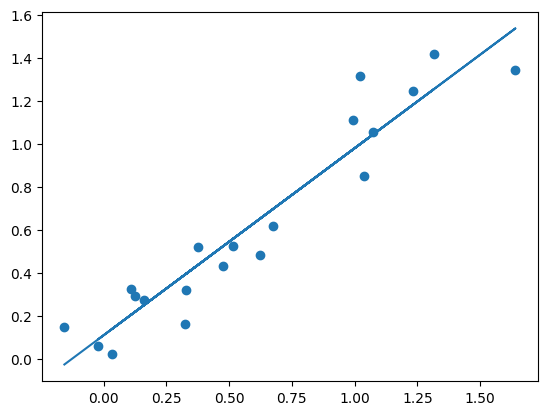

In [11]:
prediction = lm.predict(x_test[xcol])
#plt.scatter(y_test, prediction)

a, b = np.polyfit(np.array(y_test), np.array(prediction), 1)

#add points to plot
plt.scatter(np.array(y_test), prediction)

#add line of best fit to plot
plt.plot(np.array(y_test), a*y_test+b)

## Most predicted reults reside close to the best fitting line, but there are still points that are off from the line as temperature increases. 

In [12]:
column = ["co2_val", "methane_val", "Actual", "lm_predict"]
pred_df = pd.DataFrame({"co2_val": x_test["co2_val"], "methane_val": x_test["methane_val"],'Actual': y_test, 'lm_predict': prediction}, columns = column)
pred_df["lm_accuracy"] = (pred_df["lm_predict"] - pred_df["Actual"]) / pred_df["Actual"]
pred_df.head()


,co2_val,methane_val,Actual,lm_predict,lm_accuracy
4,17010.0,6432.0,-0.156378,0.146944,-1.939669
8,19070.0,6681.0,0.124216,0.291868,1.349677
24,22960.0,7360.0,0.513916,0.525869,0.023257
27,24300.0,7531.0,0.673104,0.618424,-0.081236
1,15500.0,6149.0,-0.021491,0.059801,-3.782626


## Linear model results

In [13]:
# show the accuracy of our prediction
lm_score = lm.score(x_test[xcol], y_test)
print("Accuracy is: " + str(lm.score(x_test[xcol], y_test) * 100) + "%")

Accuracy is: 89.94614835912435%


In [14]:
# mse tells how close a regression line is to a set of points
lm_mse = str(mean_squared_error(y_test, prediction))
print("Mean_squared_error is: " + lm_mse)

Mean_squared_error is: 0.024678204688053314


In [15]:
# this score estimates the skill of a machine learning model on unseen data.
lm_cross_val_scores = cross_val_score(lm, x[xcol], y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (lm_cross_val_scores.mean(), lm_cross_val_scores.std()))
# Our estimations have an accuracy of -69% compared to the actual reported data

-0.69 accuracy with a standard deviation of 0.65


In [16]:
# calculate the residual values which tells how far each prediction result is from the actual data. 
pred_df["lm_residuals"] = pred_df["Actual"] - pred_df["lm_predict"]
pred_df

,co2_val,methane_val,Actual,lm_predict,lm_accuracy,lm_residuals
4,17010.0,6432.0,-0.156378,0.146944,-1.939669,-0.303322
8,19070.0,6681.0,0.124216,0.291868,1.349677,-0.167652
24,22960.0,7360.0,0.513916,0.525869,0.023257,-0.011952
27,24300.0,7531.0,0.673104,0.618424,-0.081236,0.054680
1,15500.0,6149.0,-0.021491,0.059801,-3.782626,-0.081292
12,18880.0,6678.0,0.161720,0.274708,0.698659,-0.112987
23,22800.0,7310.0,0.376998,0.520437,0.380477,-0.143439
14,19660.0,6811.0,0.108901,0.322227,1.958899,-0.213326
39,31610.0,8525.0,0.992202,1.111718,0.120455,-0.119516
48,36650.0,9383.0,1.315488,1.419025,0.078706,-0.103537


## Polynomial Model

In [17]:
# exclude the zero exponential and get the squared value
poly = PolynomialFeatures(include_bias = False, degree = 2)
#fit and transfrom data into polynomial feature
data = poly.fit_transform(x[xcol])
poly_data = pd.DataFrame(data, columns = poly.get_feature_names_out())
poly_data.head()

,co2_val,methane_val,co2_val^2,co2_val methane_val,methane_val^2
0,14900.0,6068.0,222010000.0,90413200.0,36820624.0
1,15500.0,6149.0,240250000.0,95309500.0,37810201.0
2,16220.0,6235.0,263088400.0,101131700.0,38875225.0
3,17080.0,6388.0,291726400.0,109107040.0,40806544.0
4,17010.0,6432.0,289340100.0,109408320.0,41370624.0


## Polynomial model results

In [18]:
poly_model = Pipeline([
    ("polynomial", PolynomialFeatures(include_bias = False, degree=2)),
    ("linear_regression", LinearRegression()),
])

poly_model.fit(x_train[xcol], y_train)
poly_results = poly_model.predict(x_test[xcol])

# new data frame for polynomial model 
pred_df["poly_predict"] = poly_results

# show the accuracy of our prediction, which is the same as r2 score
#polynomial = poly_model.score(x_test, y_test)
#polynomial

# calculate the mse and r2 score (which shows the accuracy) for polymonial model
poly_mse = np.sqrt(mean_squared_error(pred_df["Actual"], pred_df["poly_predict"]))
poly_r2 = r2_score(pred_df["Actual"], pred_df["poly_predict"])
poly_mse, poly_r2

(0.1383611414260799, 0.9220085162852629)

In [19]:
# show the accuracy of our prediction, which is the same as r2 score
poly_score = poly_model.score(x_test[xcol], y_test)
poly_score

0.9220085162852629

In [20]:
# Calculate the accuracy difference between two models
dif_accuracy = (lm_score - poly_r2) * 100
dif_accuracy
# Polymonial model does slightly better than the linear model, which is 2.25 percent more accurate

-2.2547032694019475

In [21]:
# calculate the residual values which tells how far each prediction result is from the actual data. 
pred_df["poly_residual"] = pred_df["Actual"] - pred_df["poly_predict"]
pred_df

,co2_val,methane_val,Actual,lm_predict,lm_accuracy,lm_residuals,poly_predict,poly_residual
4,17010.0,6432.0,-0.156378,0.146944,-1.939669,-0.303322,-0.060793,-0.095585
8,19070.0,6681.0,0.124216,0.291868,1.349677,-0.167652,0.279434,-0.155218
24,22960.0,7360.0,0.513916,0.525869,0.023257,-0.011952,0.578408,-0.064491
27,24300.0,7531.0,0.673104,0.618424,-0.081236,0.054680,0.707406,-0.034302
1,15500.0,6149.0,-0.021491,0.059801,-3.782626,-0.081292,-0.111664,0.090173
12,18880.0,6678.0,0.161720,0.274708,0.698659,-0.112987,0.212796,-0.051075
23,22800.0,7310.0,0.376998,0.520437,0.380477,-0.143439,0.566106,-0.189108
14,19660.0,6811.0,0.108901,0.322227,1.958899,-0.213326,0.270323,-0.161422
39,31610.0,8525.0,0.992202,1.111718,0.120455,-0.119516,1.122808,-0.130606
48,36650.0,9383.0,1.315488,1.419025,0.078706,-0.103537,1.462855,-0.147366


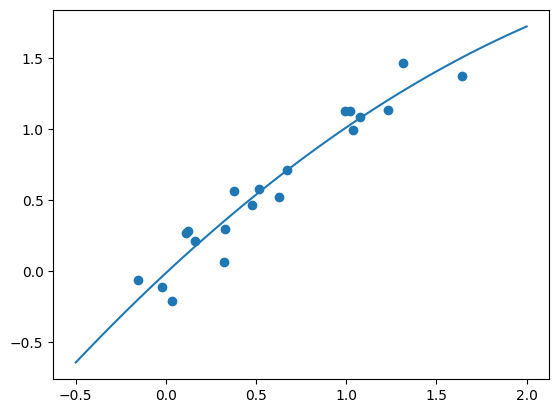

In [22]:
#plt.scatter(y_test, poly_results)
mymodel = np.poly1d(np.polyfit(y_test, poly_results, 2))

myline = np.linspace(start=-0.5,stop=2)

plt.scatter(y_test, poly_results)
plt.plot(myline, mymodel(myline))
plt.show()

### Conclusion: The polynomial model with a degree of 2 has a better accuracy compared to the linear model. By looking at the plots of predicted results from both models we can tall that the points in the polynomial model resides closer to the best fitting line and look more gathered to each other. But the polynomial model has a higher calculated mean squared error, which indicates a higher variance. Future possible improvements on this are: finding more related data that lead to increase in global warming and also include non_numerical data while prediciting the temeperatue.

## Add another column of categorical data to predict the average global temperature

In [23]:
oh = OneHotEncoder()
categorical = oh.fit_transform(combined_data[["below_zero"]]).toarray()
category_df = pd.DataFrame(categorical, columns = oh.get_feature_names_out())
category_df.head()

,below_zero_no,below_zero_yes
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0


In [24]:
# combine the numerical data and categorical data together for a better consistency of data
transformer = make_column_transformer(
            (OneHotEncoder(), ["below_zero"]), 
            (PolynomialFeatures(2, include_bias=False), ["co2_val", "methane_val"]),
        )

# "StandardScaler()" helps resize the distribution of the training data so that the mean of the 
# observed values is 0 and the standard deviation is 1 for a purpose of a more accurate prediction
pipe = Pipeline([
            ("trans", transformer),
            ("std", StandardScaler()),
            ("lr", LinearRegression()),
        ])
pipe.fit(x_train, y_train)
oh_results = pipe.predict(x_test)
pred_df["oh_predict"] = oh_results

In [25]:
# The accuracy is increased to 93.698% with the categorical column being added!
oh_score = pipe.score(x_test, y_test)
oh_score

0.9369844007299201

In [26]:
# Calculate the accuracy difference between two the poly model and the categorical pipe
accuracy_dif = (poly_score - oh_score) * 100
accuracy_dif
# Polymonial model does slightly better than the linear model, which is close to 1.498 percent more accurate

-1.497588444465714

In [27]:
# calculate the residual values which tells how far each prediction result is from the actual data. 
pred_df["oh_residual"] = pred_df["Actual"] - pred_df["oh_predict"]
pred_df

,co2_val,methane_val,Actual,lm_predict,lm_accuracy,lm_residuals,poly_predict,poly_residual,oh_predict,oh_residual
4,17010.0,6432.0,-0.156378,0.146944,-1.939669,-0.303322,-0.060793,-0.095585,-0.082241,-0.074137
8,19070.0,6681.0,0.124216,0.291868,1.349677,-0.167652,0.279434,-0.155218,0.354686,-0.230470
24,22960.0,7360.0,0.513916,0.525869,0.023257,-0.011952,0.578408,-0.064491,0.545699,-0.031782
27,24300.0,7531.0,0.673104,0.618424,-0.081236,0.054680,0.707406,-0.034302,0.660744,0.012360
1,15500.0,6149.0,-0.021491,0.059801,-3.782626,-0.081292,-0.111664,0.090173,-0.045402,0.023911
12,18880.0,6678.0,0.161720,0.274708,0.698659,-0.112987,0.212796,-0.051075,0.277285,-0.115565
23,22800.0,7310.0,0.376998,0.520437,0.380477,-0.143439,0.566106,-0.189108,0.536983,-0.159985
14,19660.0,6811.0,0.108901,0.322227,1.958899,-0.213326,0.270323,-0.161422,0.309088,-0.200187
39,31610.0,8525.0,0.992202,1.111718,0.120455,-0.119516,1.122808,-0.130606,1.076069,-0.083867
48,36650.0,9383.0,1.315488,1.419025,0.078706,-0.103537,1.462855,-0.147366,1.499539,-0.184050


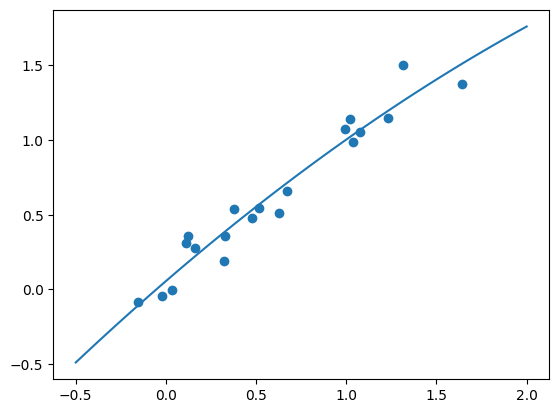

In [28]:
oh_model = np.poly1d(np.polyfit(y_test, oh_results, 2))

myline = np.linspace(start=-0.5,stop=2)

plt.scatter(y_test, oh_results)
plt.plot(myline, oh_model(myline))
plt.show()

## By adding another categorical column to the regression model, we increased the accuracy to 93.698% which is about 1.498% higher then the polynimial model. The points lie slightly closer to the best fitting line compared to the plot we had for the polynomial mode. Next possible step we will do is to find more toxic gas emission data and some other potentially useful categorical data to further predict the temperature and increase the model accuracy. 